In [1]:
import sys
import os
# 获取套件的路径
package_path = os.path.join(os.getcwd(), '/Users/chieray/TMBA-ATD-coding/因子研究/python')  # 替换为你套件的实际路径
sys.path.append('/Users/chieray/TMBA-ATD-coding/因子研究/python')
import get_data
import factor_generator
import factor_merger
import foctorvaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tejapi
import pickle
import optuna
import time
#from scripts.config import *
#from scripts.factors import *
#from data.scripts.load_data import DataManager
import shioaji as sj
import statsmodels.api as sm

/Users/chieray/TMBA-ATD-coding/因子研究/python/get_data.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['symbol', 'name']] = df['symbol'].str.split(n=1, expand=True)
/Users/chieray/TMBA-ATD-coding/因子研究/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-13 23:55:02.016 | WARNING  | importlib._bootstrap:_call_with_frames_removed:241 - Optional: pip install shioaji[speed] for better performance.


In [ ]:
import yfinance as yf
tickers = ["IAU", "VT", "SCHE"]#, "TMF", "TYD"]
start_date = "2011-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
price_data = yf.download(tickers, start=start_date, end=end_date)["Open"]
exp_reruen=(price_data.shift(-2)/price_data.shift(-1))-1
rolling_std=(exp_reruen.shift(2).rolling(252).std())
weighting=rolling_std.div(rolling_std.sum(axis=1),axis=0)
return_se=(exp_reruen*weighting).sum(axis=1)
# 檢查數據
return_se.cumsum().plot()

In [2]:
sys.path.append('/Users/chieray/Library/CloudStorage/GoogleDrive-smcjerry8@gmail.com/我的雲端硬碟/mbq')
from TQuantLab_Data.scripts.load_data import DataManager
manager = DataManager()
manager.list_datasets()

可用的資料集:
- 證券屬性資料表
- 月營收
- 股利政策
- 資本形成
- 集保庫存
- 三大法人_融資券_當沖
- 股價交易資訊
- 股票日交易註記資訊
- 交易日期表
- 會計師簽證財務資料
- 公司自結數
- 合併收購
- 董事長與高階主管變動事件
- 全面改選統計
- 董監全體持股狀況
- 庫藏股實施事件簿
- 董監申報轉讓_未轉讓
- 董監申報轉讓_轉讓
- 私募應募人與公司的關係
- 月營收_法人機構專屬版本


# 寫策略

### 報酬率資料

In [3]:
調整係數=manager.tool_api_data("調整係數")
adjopen=manager.tool_api_data("開盤價")['Open']*調整係數['Adjust_Factor']
adjhigh=manager.tool_api_data("最高價")['High']*調整係數['Adjust_Factor']
adjlow=manager.tool_api_data("最低價")['Low']*調整係數['Adjust_Factor']
adjclose=manager.tool_api_data("收盤價")['Close']*調整係數['Adjust_Factor']
adjprice=(adjopen+adjhigh+adjlow+adjclose)/4
adjprice=adjopen.shift(-1)
#monthadjprice=resample_to_period(adjprice, period=period)
exp_monthreturn=(adjprice.shift(-1)/adjprice)-1

資料集 '調整係數' 包含其他欄位（['Adjust_Factor']），進行 pivot 操作。
資料集 '開盤價' 包含其他欄位（['Open']），進行 pivot 操作。
資料集 '最高價' 包含其他欄位（['High']），進行 pivot 操作。
資料集 '最低價' 包含其他欄位（['Low']），進行 pivot 操作。
資料集 '收盤價' 包含其他欄位（['Close']），進行 pivot 操作。


In [32]:
###data from MBQ
market=manager.get_data('股價交易資訊',common_stock = False)
market=market[market['證券名稱']=='IX0001']
market['年月'] = pd.to_datetime(market['資料日'], format='%Y/%m/%d')
market.rename(columns= {'年月': 'datetime'}, inplace=True)
market=market.set_index('datetime')
mkprice=market['開盤價']
mkprice=mkprice.shift(-1)
market_return=(mkprice.shift(-1)/mkprice)-1

### 事件區

In [4]:
每股盈餘=manager.tool_api_data("每股稅後淨利")['Net_Income_Per_Share_Q']
每股盈餘創新高=每股盈餘>=每股盈餘.rolling(252).max()
單月營收=manager.tool_api_data("單月營收_千元")['Sales_Monthly']#['Month_Sales_Compared_To_High_Month_Sales_MoM']
營收創x期新高=單月營收>=單月營收.rolling(252).max()
營收創歷史新高 = (單月營收 >= 單月營收.expanding(min_periods=1).max())

資料集 '每股稅後淨利' 包含其他欄位（['Net_Income_Per_Share_A', 'Net_Income_Per_Share_Q', 'Net_Income_Per_Share_TTM']），進行 pivot 操作。
資料集 '單月營收_千元' 包含其他欄位（['Sales_Monthly']），進行 pivot 操作。


In [20]:
事件=每股盈餘創新高
持倉天數=20

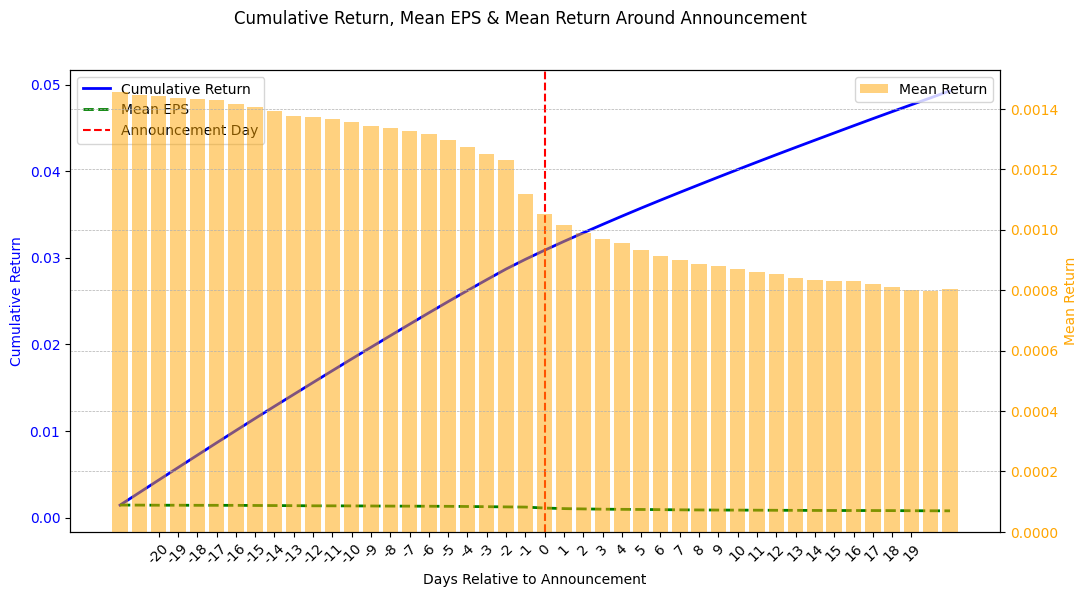

In [6]:
import numpy as np
import matplotlib.pyplot as plt
mean_returns = []
mean_eps = []
for i in range(-22, 22):  
    mean_returns.append(exp_monthreturn.shift(int(-1*(i+1)))[事件].mean(axis=1).mean())
    mean_eps.append(exp_monthreturn.shift(int(-1*(i)))[事件].mean(axis=1).mean())
cumulative_returns = np.array(mean_returns).cumsum()
event_days = list(range(-22, 22))
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(event_days,cumulative_returns, label="Cumulative Return", color="b", linewidth=2)
ax1.set_xlabel("Days Relative to Announcement")
ax1.set_ylabel("Cumulative Return", color="b")
ax1.tick_params(axis="y", labelcolor="b")
ax1.plot(event_days, mean_eps, label="Mean EPS", color="green", linewidth=2, linestyle="dashed")
ax2 = ax1.twinx()
ax2.bar(event_days, mean_returns, label="Mean Return", color="orange", alpha=0.5)
ax2.set_ylabel("Mean Return", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")
ax1.axvline(x=0, color="r", linestyle="--", label="Announcement Day")
xticks = np.arange(-20, 20, 1)  # 範圍從 -250 到 250，每 10 為一單位
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=45)  # 旋轉標籤以防止重疊
fig.suptitle("Cumulative Return, Mean EPS & Mean Return Around Announcement")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [128]:
###要想想
class data_prehandle:
    def __init__(self,period):
        self.period = period

In [ ]:
###因子前處理
#combined_factor_mad_neu_std =factor_generator.extreme_mad(combined_factor, n=3)
#industry_codes = industry.stack().unique().tolist()
#industry_codes = [code for code in industry_codes if isinstance(code, str)]
#encoded_industries = {code: (industry == code).astype(int) for code in industry_codes}
#industry_dummies = [encoded_industries[ind] for ind in industry_codes]
#combined_factor_mad_neu_std =factor_generator.Neutralization(combined_factor_mad_neu_std, *industry_dummies,cap)
#combined_factor_mad_neu_std =combined_factor_mad_neu_std.rank(axis=1, pct=True)

### 因子區

In [21]:
事件後x日總報酬=exp_monthreturn.shift(-1*int(持倉天數)).rolling(int(持倉天數)).sum()

In [22]:
短期報酬=(exp_monthreturn.shift(2).rolling(22).mean())/(exp_monthreturn.shift(2).rolling(22).std())   
營收mom_ts_rank=((單月營收-單月營收.shift(252))/abs(單月營收.shift(252))).rolling(252).rank(pct=True)
營收sue_flow=(((單月營收-單月營收.shift(252))-(單月營收-單月營收.shift(252)).rolling(252).mean())/(單月營收-單月營收.shift(252)).rolling(252).std())

In [23]:
回歸資料 = pd.concat({'持倉報酬率':事件後x日總報酬[事件].stack(),
                    '短期報酬':短期報酬[事件].stack(),
                    '營收mom_ts_rank':營收mom_ts_rank[事件].stack(),
                    '營收sue_flow':營收sue_flow[事件].stack(),},axis=1)

回歸資料 =回歸資料.dropna()

In [24]:
X = 回歸資料[["短期報酬", "營收sue_flow"]]
y = 回歸資料["持倉報酬率"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
result=model.summary()
print(result)

                            OLS Regression Results                            
Dep. Variable:                  持倉報酬率   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     591.6
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          1.90e-257
Time:                        23:59:15   Log-Likelihood:             5.4699e+05
No. Observations:              784481   AIC:                        -1.094e+06
Df Residuals:                  784478   BIC:                        -1.094e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0185      0.000    131.651      0.0

### 回測區

In [11]:
短期報酬門檻= (短期報酬.notna().sum(axis=1) * 0.5).round()
短期報酬濾網= 短期報酬.rank(axis=1, ascending=True).le(短期報酬門檻, axis=0)

未預期營收門檻= (營收sue_flow.notna().sum(axis=1) * 0.5).round()
未預期營收濾網= 營收sue_flow.rank(axis=1, ascending=True).le(未預期營收門檻, axis=0)

In [12]:
最終進場訊號=短期報酬濾網&事件&未預期營收濾網

In [25]:
aum=2000000
close=manager.tool_api_data("收盤價")['Close']
weight=(np.floor(0.1 * aum / (close*1000)) * (close*1000)) /aum
weight_ff=weight[最終進場訊號].ffill(limit=int(持倉天數))

資料集 '收盤價' 包含其他欄位（['Close']），進行 pivot 操作。


In [26]:
class StockSelector:
    def __init__(self, stock_num, price_df):
        self.params = {'stock_num': stock_num}
        self.price_df = price_df

    def limit_true_values(self, df, max_true=None):
        max_true = max_true or self.params['stock_num']
        values = df.values
        result = values.copy()
        prev_true = np.array([], dtype=int)
        
        for i in range(len(values)):
            current_true = np.where(values[i])[0]
            
            if len(current_true) > max_true:
                prices = self.price_df.values[i][current_true]
                keep = np.intersect1d(current_true, prev_true)
                
                if len(keep) < max_true:
                    remaining = np.setdiff1d(current_true, keep)
                    remaining_idx = np.argsort(prices[~np.isin(current_true, keep)])
                    keep = np.concatenate([keep, remaining[remaining_idx[:max_true - len(keep)]]])
                
                result[i] = np.isin(np.arange(values.shape[1]), keep)
            
            prev_true = np.where(result[i])[0]
        
        return pd.DataFrame(result, index=df.index, columns=df.columns)

In [27]:
selector = StockSelector(stock_num=10, price_df=close)
position = selector.limit_true_values(weight_ff)

In [28]:
return_se=(weight*position*exp_monthreturn).sum(axis=1)

In [29]:
def manage_positions(signals_df, scores_df, max_positions=20, score_threshold=0):
    adjusted_signals = signals_df.copy()
    position_entry_times = pd.DataFrame(index=signals_df.index, columns=signals_df.columns)

    for current_date in signals_df.index:
        if current_date == signals_df.index[0]:
            current_signals = signals_df.loc[current_date]
            current_scores = scores_df.loc[current_date]

            # 加入分數下限的條件
            valid_signals = current_signals & current_scores.notna() & (current_scores >= score_threshold)

            if valid_signals.sum() > max_positions:
                selected_stocks = current_scores[valid_signals].nlargest(max_positions).index
                adjusted_signals.loc[current_date] = False
                adjusted_signals.loc[current_date, selected_stocks] = True
            else:
                adjusted_signals.loc[current_date] = valid_signals

            position_entry_times.loc[current_date] = np.where(
                adjusted_signals.loc[current_date],
                current_date,
                pd.NaT
            )
        else:
            prev_date = adjusted_signals.index[adjusted_signals.index.get_loc(current_date) - 1]
            prev_positions = adjusted_signals.loc[prev_date]
            current_signals = signals_df.loc[current_date]
            current_scores = scores_df.loc[current_date]

            keep_positions = prev_positions & current_signals
            adjusted_signals.loc[current_date] = keep_positions

            current_positions = keep_positions.sum()
            available_slots = max_positions - current_positions

            if available_slots > 0:
                new_entries = current_signals & ~keep_positions & current_scores.notna() & (current_scores >= score_threshold)

                if new_entries.sum() > available_slots:
                    new_selected = current_scores[new_entries].nlargest(int(available_slots)).index
                    adjusted_signals.loc[current_date, new_selected] = True
                else:
                    adjusted_signals.loc[current_date, new_entries] = True

            new_entries = adjusted_signals.loc[current_date] & ~prev_positions
            position_entry_times.loc[current_date] = np.where(
                new_entries,
                current_date,
                position_entry_times.loc[prev_date]
            )

    return adjusted_signals, position_entry_times

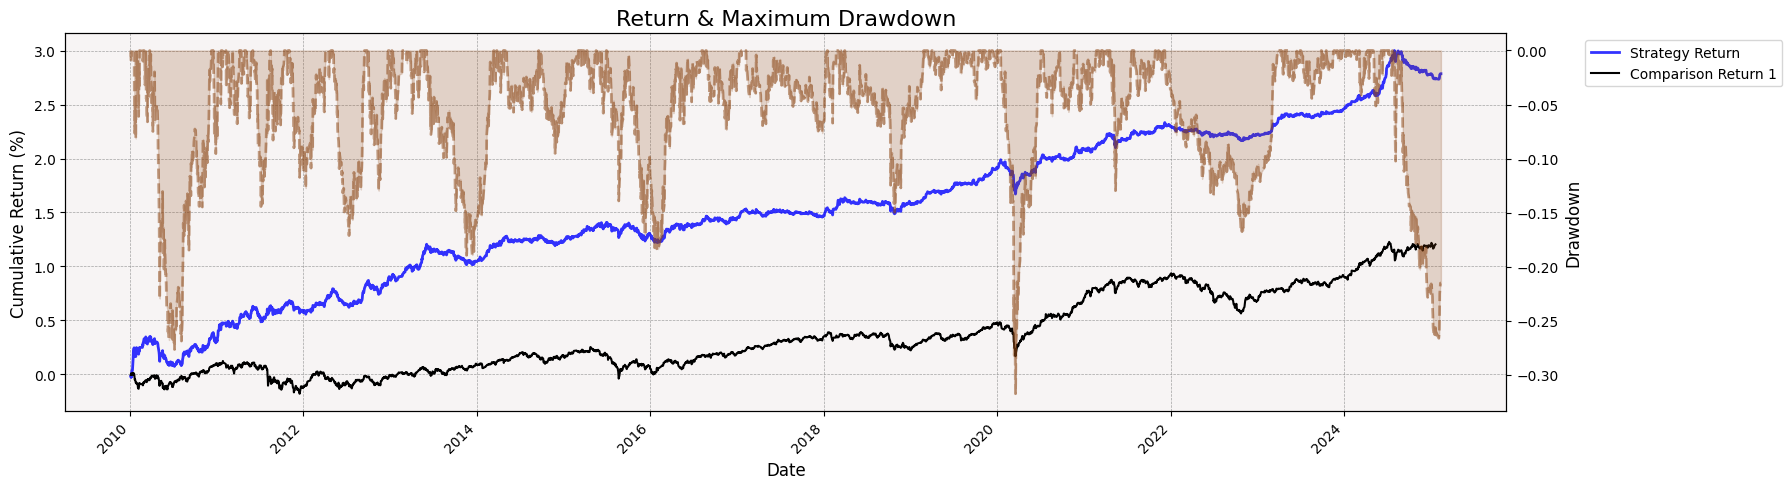

In [33]:
foctorvaluation.plot_compare_return(return_se,market_return)

In [31]:
foctorvaluation.calculate_metrics_day(return_se)

/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:447: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_win_rate = round(returns.resample('M').apply(lambda x: 1 + x.sum() > 1).mean() * 100, 2)
/Users/chieray/TMBA-ATD-coding/因子研究/python/foctorvaluation.py:448: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_win_rate = round(returns.resample('Y').apply(lambda x: 1 + x.sum() > 1).mean() * 100, 2)


年化收益率(%)          20.86
年化标准差(%)          17.84
年化夏普比率             1.06
诺丁比率               1.54
卡玛比率               0.66
在市场上时间(%)         99.95
MDD(%)           -31.77
最长回撤日数           313.00
Profit Factor      1.21
日胜率(%)            52.65
周胜率(%)            54.25
月胜率(%)            61.54
年胜率(%)            93.75
dtype: float64